In [1]:
#Pelayo Leguina - 2024

#Este script permite convertir un archivo ROOT con clases tipo TClonesArray a un DataFrame de pandas.

# Para correr este script es necesario tener instalado ROOT y pandas
# Para tener root instalado, hay que generar el env con conda. 
# Mira el archivo environment.yml para ver como hacerlo. Una vez tengas el env creado, activa el env y ejecuta este notebook. 
# Puedes seguir trabajando aqui o exportar el dataframe a un archivo csv para trabajar en otro lado.

import ROOT
import pandas as pd

# Definir la ruta del archivo ROOT y el nombre del arbol
ruta_archivo_root = '../dtTuples/DTDPGNtuple_12_4_2_Phase2Concentrator_Simulation_89.root'
nombre_arbol = 'dtNtupleProducer/DTTREE'


In [2]:

# Abrir el archivo ROOT
archivo = ROOT.TFile.Open(ruta_archivo_root)
if not archivo or archivo.IsZombie():
    raise FileNotFoundError(f"No se pudo abrir el archivo ROOT en {ruta_archivo_root}")


In [3]:

# Obtener el arbol
arbol = archivo.Get(nombre_arbol)
if not arbol:
    raise ValueError(f"No se encontro el arbol '{nombre_arbol}' en el archivo ROOT.")

# Obtener el numero de eventos en el arbol
numero_eventos = arbol.GetEntries()
print(f"El arbol tiene {numero_eventos} eventos.")


El arbol tiene 439 eventos.


In [4]:

# Listas de ramas
ramas_event = ['event_eventNumber']
ramas_digis_numericas = ["digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"]
ramas_seg_numericas = [
    "seg_nSegments", "seg_wheel", "seg_sector", "seg_station", "seg_hasPhi", 
    "seg_hasZed", "seg_posLoc_x", "seg_posLoc_y", "seg_posLoc_z", 
    "seg_dirLoc_x", "seg_dirLoc_y", "seg_dirLoc_z", "seg_posLoc_x_SL1", 
    "seg_posLoc_x_SL3", "seg_posLoc_x_midPlane", "seg_posGlb_phi", 
    "seg_posGlb_eta", "seg_dirGlb_phi", "seg_dirGlb_eta", "seg_phi_t0", 
    "seg_phi_vDrift", "seg_phi_normChi2", "seg_phi_nHits", 
    "seg_z_normChi2", "seg_z_nHits"
]
ramas_seg_arrays = [
    'seg_phiHits_pos', 'seg_phiHits_posCh', 'seg_phiHits_posErr', 
    'seg_phiHits_side', 'seg_phiHits_wire', 'seg_phiHits_wirePos', 
    'seg_phiHits_layer', 'seg_phiHits_superLayer', 'seg_phiHits_time', 
    'seg_phiHits_timeCali'
]

ramas_a_extraer = ramas_event + ramas_digis_numericas + ramas_seg_numericas + ramas_seg_arrays


In [5]:

# Inicializar diccionario para almacenar los datos
data = {rama: [] for rama in ramas_a_extraer}

# Obtener el numero de eventos en el arbol
numero_eventos = arbol.GetEntries()
print(f"El arbol tiene {numero_eventos} eventos.")


El arbol tiene 439 eventos.


In [6]:
from collections import defaultdict
import time

data = defaultdict(list)

max_eventos = 10000

start_total = time.time()

# Iterar sobre las entradas del arbol
for i, evento in enumerate(arbol):
    start_event = time.time()
    if i >= max_eventos:
        break  # Detener el bucle cuando se alcanzan max_eventos
    for rama in ramas_a_extraer:
        valor = getattr(evento, rama, None)
        
        if valor is None:
            data[rama].append(None)
            continue

        # Optimizacion: manejar TClonesArray
        if hasattr(valor, 'GetEntriesFast'):
            n_entries = valor.GetEntriesFast()  # Guardar numero de entradas
            valores = [
                [x for x in valor.At(i)] if hasattr(valor.At(i), '__len__') else valor.At(i)
                for i in range(n_entries)
            ]
            data[rama].append(valores)
        elif isinstance(valor, (ROOT.TVectorF, ROOT.TVectorD)):
            # Optimizacion: convertir directamente a lista
            data[rama].append(list(valor))
        elif isinstance(valor, (int, float)):
            # Escalar simple
            data[rama].append(valor)
        else:
            try:
                # Intentar convertir a lista si es iterable
                data[rama].append(list(valor))
            except TypeError:
                data[rama].append(valor)
    end_event = time.time()
    if i%100==0:
        print(f"Evento {i+1}: {end_event - start_event:.2f} segundos")

end_total = time.time()
print(f"Tiempo total: {end_total - start_total:.2f} segundos")
# Cerrar el archivo ROOT
archivo.Close()
#tarda como 1 minuto

Evento 1: 0.08 segundos
Evento 101: 0.00 segundos
Evento 201: 0.00 segundos
Evento 301: 0.01 segundos
Evento 401: 0.00 segundos
Tiempo total: 2.59 segundos


In [7]:
# Verificar que todas las ramas tienen la misma longitud
longitudes = {rama: len(val) for rama, val in data.items()}
print("Longitud de cada rama:")

for rama, longitud in longitudes.items():
    print(f"{rama}: {longitud}")

# Convertir a DataFrame
try:
    df = pd.DataFrame(data)
except ValueError as e:
    print("Error al crear el DataFrame:", e)
    for rama, longitud in longitudes.items():
        print(f"{rama}: {longitud}")
    raise

# Mostrar una vista previa del DataFrame
print("\nVista previa del DataFrame:")
df.head()

# Contar los hits en las ramas tipo array
for rama in ramas_seg_arrays:
    if rama in df.columns:
        df[f'{rama}_count'] = df[rama].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Mostrar conteos
for rama in ramas_seg_arrays:
    if f'{rama}_count' in df.columns:
        print(f"\nNumero de hits por evento en '{rama}':")
        print(df[f'{rama}_count'].head())

# Guardar el DataFrame en un archivo CSV
df.to_csv('data.csv', index=False)
print('Data saved in data.csv')

#Ahora ya puedes trabajar con el df para generar las entradas/verdades de tu modelo de ML
#Siempre asegurate de preprocesar el df, rellenar los NaNs, normalizar los datos, etc.

#Recuerda que deberiamos filtrar los digis pertenecientes a la SL2 (no trabajamos en esa dimension)
#Lo mismo para los segmentos que no tienen hits en phi (son segmentos de la SL2 y tambien tenemos que cargarnoslos)
# Suerte! :)

Longitud de cada rama:
event_eventNumber: 439
digi_nDigis: 439
digi_wheel: 439
digi_sector: 439
digi_station: 439
digi_superLayer: 439
digi_layer: 439
digi_wire: 439
digi_time: 439
seg_nSegments: 439
seg_wheel: 439
seg_sector: 439
seg_station: 439
seg_hasPhi: 439
seg_hasZed: 439
seg_posLoc_x: 439
seg_posLoc_y: 439
seg_posLoc_z: 439
seg_dirLoc_x: 439
seg_dirLoc_y: 439
seg_dirLoc_z: 439
seg_posLoc_x_SL1: 439
seg_posLoc_x_SL3: 439
seg_posLoc_x_midPlane: 439
seg_posGlb_phi: 439
seg_posGlb_eta: 439
seg_dirGlb_phi: 439
seg_dirGlb_eta: 439
seg_phi_t0: 439
seg_phi_vDrift: 439
seg_phi_normChi2: 439
seg_phi_nHits: 439
seg_z_normChi2: 439
seg_z_nHits: 439
seg_phiHits_pos: 439
seg_phiHits_posCh: 439
seg_phiHits_posErr: 439
seg_phiHits_side: 439
seg_phiHits_wire: 439
seg_phiHits_wirePos: 439
seg_phiHits_layer: 439
seg_phiHits_superLayer: 439
seg_phiHits_time: 439
seg_phiHits_timeCali: 439

Vista previa del DataFrame:

Numero de hits por evento en 'seg_phiHits_pos':
0    17
1     7
2    11
3    10
4

In [8]:
from newGeo.dtGeometry import *
from itertools import chain
import logging

geometry_xml_path = "newGeo/DTGeometry.xml"


# Parse DT Geometry XML
print("\nParsing DT Geometry XML...")
df_geometry = parse_dtgeometry_xml(geometry_xml_path)

def create_wire_position_mapping(df_geometry):
    mapping = {}
    for idx, row in df_geometry.iterrows():
        chamber_rawId = row['Chamber_rawId']
        superLayerNumber = row['SuperLayerNumber']
        layerNumber = row['LayerNumber']
        channels_total = row['Channels_total']
        wireFirst = row['WirePositions_FirstWire']
        wireLast = row['WirePositions_LastWire']
        # Create Wire object to get positions
        wire_obj = Wire(wireFirst, wireLast, channels_total, row['Layer_Local_z'])
        # Map wire numbers to positions
        for wire_idx, x_pos in enumerate(wire_obj.positions):
            wire_number = wire_idx + 1  # Assuming wire numbers start from 1
            key = (chamber_rawId, superLayerNumber, layerNumber, wire_number)
            mapping[key] = x_pos
    return mapping

def explode_dataframe(df, list_columns):
    """Explota columnas con listas en filas separadas."""
    # Repetir indices segun la longitud de las listas
    lengths = df[list_columns[0]].apply(len)
    idx = df.index.repeat(lengths)

    # Explotar las columnas de listas
    exploded_data = {col: list(chain.from_iterable(df[col])) for col in list_columns}

    # Agregar las columnas que no son listas
    exploded_df = pd.DataFrame(exploded_data, index=idx)
    non_list_columns = df.columns.difference(list_columns)
    for col in non_list_columns:
        exploded_df[col] = df[col].repeat(lengths)

    return exploded_df.reset_index(drop=True)

def add_chamber_rawId_to_digis(df):
    """Agrega la columna chamber_rawId basada en wheel, station y sector."""
    chamber_rawIds = []
    for idx, row in df.iterrows():
        try:
            rawId = get_rawId(row['digi_wheel'], row['digi_station'], row['digi_sector'])
        except ValueError as e:
            logging.error(f"Error al calcular rawId en el indice {idx}: {e}")
            rawId = None
        chamber_rawIds.append(rawId)
    df['digi_chamber_rawId'] = chamber_rawIds
    return df

def map_digi_wires_to_positions(df, wire_position_mapping):
    """Mapea los wires a sus posiciones en x usando wire_position_mapping."""
    x_positions = []
    for idx, row in df.iterrows():
        key = (row['digi_chamber_rawId'], row['digi_superLayer'], row['digi_layer'], row['digi_wire'])
        x_pos = wire_position_mapping.get(key, None)  # Por defecto, None si no se encuentra la clave
        x_positions.append(x_pos)
    df['digi_x_pos'] = x_positions
    return df

def reconstruct_dataframe(df_original, df_flattened, list_columns, extra_columns):
    """
    Reconstruye el DataFrame original, agrupando las columnas calculadas en listas.

    Args:
    - df_original: DataFrame original con listas.
    - df_flattened: DataFrame aplanado despues de las explosiones y calculos.
    - list_columns: Columnas que originalmente estaban en formato de lista.
    - extra_columns: Nuevas columnas a agregar al DataFrame.

    Returns:
    - DataFrame reconstruido con las columnas adicionales.
    """
    # Crear indice auxiliar para asociar filas a las originales
    df_flattened["original_index"] = df_original.index.repeat(
        df_original[list_columns[0]].apply(len)
    )

    # Agrupar filas aplanadas segun el indice original
    grouped = df_flattened.groupby("original_index")

    # Agregar de vuelta las columnas originales y las nuevas
    for col in list_columns + extra_columns:
        df_original[col] = grouped[col].apply(list).reindex(df_original.index).tolist()

    return df_original

wire_position_mapping = create_wire_position_mapping(df_geometry)

# Columnas con valores en listas
list_columns = ['digi_wheel', 'digi_sector', 'digi_station', 'digi_superLayer', 'digi_layer', 'digi_wire']

# Explotar el DataFrame para trabajar con cada digi individualmente
df_flattened = explode_dataframe(df, list_columns)

# Agregar la columna chamber_rawId
df_flattened = add_chamber_rawId_to_digis(df_flattened)

# Calcular las posiciones de los wires
df_flattened = map_digi_wires_to_positions(df_flattened, wire_position_mapping)

# Reconstruir el DataFrame original con la nueva columna
df = reconstruct_dataframe(df, df_flattened, list_columns, ['digi_x_pos'])

# Reordenar columnas para que digi_x_pos aparezca despues de digi_wire
columns = df.columns.tolist()
digi_wire_index = columns.index('digi_wire')
columns.insert(digi_wire_index + 1, columns.pop(columns.index('digi_x_pos')))
df = df[columns]

# Mostrar el DataFrame final 
#print(df.head())
#tarda como 3 min


Parsing DT Geometry XML...


In [9]:
# Ramas relacionadas con 'digis'
ramas_digis = [
    "event_eventNumber",
    "digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"
]

# Ramas relacionadas con 'segments' (seg)
ramas_segments = [
    "event_eventNumber",
    "seg_nSegments",
    "seg_wheel",
    "seg_sector",
    "seg_station",
    "seg_hasPhi",
    "seg_hasZed",
    "seg_posLoc_x",
    "seg_posLoc_y",
    "seg_posLoc_z",
    "seg_dirLoc_x",
    "seg_dirLoc_y",
    "seg_dirLoc_z",
    "seg_posLoc_x_SL1",
    "seg_posLoc_x_SL3",
    "seg_posLoc_x_midPlane",
    "seg_posGlb_phi",
    "seg_posGlb_eta",
    "seg_dirGlb_phi",
    "seg_dirGlb_eta",
    "seg_phi_t0",
    "seg_phi_vDrift",
    "seg_phi_normChi2",
    "seg_phi_nHits",
    "seg_z_normChi2",
    "seg_z_nHits",
    "seg_phiHits_wire",
    "seg_phiHits_layer",
    "seg_phiHits_superLayer"
]

# Combinar todas las ramas a extraer
ramas_a_extraer = ramas_digis + ramas_segments

In [10]:
# Extraer las ramas relacionadas con 'digis' en un DataFrame de pandas
df_digis = df[ramas_digis]

# Extraer las ramas relacionadas con 'segments' en otro DataFrame de pandas
df_segments = df[ramas_segments]

In [11]:
# Funcion para convertir Awkward Arrays a listas de Python
def convertir_a_lista(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    return [x]  # En caso de que sea un valor escalar, lo convertimos en lista

# Aplicar la conversion a todas las columnas de 'digis' que son listas ( excepto 'event_eventNumber' )  

for col in ramas_digis:
    df_digis.loc[:, col] = df_digis[col].apply(convertir_a_lista)

for col in ramas_segments:
    df_segments.loc[:, col] = df_segments[col].apply(convertir_a_lista)

/tmp/ipykernel_24644/200737374.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[list([52244]) list([52251]) list([52242]) list([52254]) list([52248])
 list([52247]) list([52250]) list([52256]) list([52245]) list([52249])
 list([52246]) list([52252]) list([52243]) list([52255]) list([52259])
 list([52260]) list([52253]) list([52266]) list([52265]) list([52263])
 list([52257]) list([52270]) list([52262]) list([52258]) list([52261])
 list([52267]) list([52269]) list([52273]) list([52271]) list([52274])
 list([52272]) list([52275]) list([52268]) list([52278]) list([52277])
 list([52281]) list([52264]) list([52283]) list([52276]) list([52282])
 list([52280]) list([52285]) list([52287]) list([52284]) list([52279])
 list([52291]) list([52289]) list([52286]) list([52288]) list([52292])
 list([52290]) list([52296]) list([52295]) list([52298]) list([52297])
 list([52299]) list([52300]) list([52294]) list([52293]) list([

### Primero manupulo los digis

In [12]:
# Definir las columnas relacionadas con 'digis' que seran aplanadas
columns_to_explode_digis = ['digi_superLayer', 'digi_layer', 'digi_wire', 'digi_time', 'digi_wheel', 'digi_sector', 'digi_station']

# Funcion para verificar si todas las listas tienen la misma longitud en una fila
def verificar_longitudes(row, cols):
    lengths = [len(row[col]) for col in cols]
    return len(set(lengths)) == 1  # True si todas las longitudes son iguales

# Aplicar la funcion a cada fila
# Asignar la columna 'same_length' usando .loc
df_digis['same_length'] = df_digis.apply(lambda row: verificar_longitudes(row, columns_to_explode_digis), axis=1)

# Verificar cuantas filas cumplen la condicion
print("Numero de filas con listas de la misma longitud en 'digis':")
print(df_digis['same_length'].value_counts())

# Filtrar solo las filas que cumplen la condicion
df_digis = df_digis[df_digis['same_length']]

# Eliminar la columna auxiliar
df_digis = df_digis.drop(columns=['same_length'])


Numero de filas con listas de la misma longitud en 'digis':
same_length
True    439
Name: count, dtype: int64


/tmp/ipykernel_24644/1437617869.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_digis['same_length'] = df_digis.apply(lambda row: verificar_longitudes(row, columns_to_explode_digis), axis=1)


In [13]:
# ahora vamos a aplanar las columnas de 'digis' que contienen listas
columns_to_explode_digis = [
    'digi_superLayer', 'digi_layer', 'digi_wire', 
    'digi_time', 'digi_wheel', 'digi_sector', 'digi_station'
]

df_digis_exploded = df_digis.explode(columns_to_explode_digis)

# Renombrar las columnas a nombres mas cortos
df_digis_exploded = df_digis_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "digi_superLayer": "superLayer",
    "digi_layer": "layer",
    "digi_wire": "wire",
    "digi_time": "time",
    "digi_wheel": "wheel",
    "digi_sector": "sector",
    "digi_station": "station"
})

# Convertir 'event_eventNumber' a entero, ya que antes era una lista
df_digis_exploded['eventNumber'] = df_digis_exploded['eventNumber'].apply(lambda x: x if isinstance(x, (int, str)) else x[0])

# Eliminar la columna 'digi_nDigis' ya que no es necesaria, puesto que cuenta el numero de digis en cada evento, no de cada estacion
df_digis_exploded = df_digis_exploded.drop(columns=['digi_nDigis'])
# ELiminamos los digis de la superLayer 2, ya que no son necesarios y pueden influir en los resultados
df_digis_exploded = df_digis_exploded[df_digis_exploded['superLayer'] != 2]
df_digis_exploded = df_digis_exploded[df_digis_exploded['superLayer'] == 1]

In [14]:
# Ahora vamos a agrupar los digis por evento y estacion
df_digis_grouped = df_digis_exploded.groupby(
    ['eventNumber', 'wheel', 'sector', 'station']
).agg({
    'superLayer': list,
    'layer': list,
    'wire': list,
    'time': list
}).reset_index()

df_digis_grouped['n_digis'] = df_digis_grouped['wire'].apply(len)

# Mostrar una vista previa despues de aplanar
tamaño_bytes = df_digis_grouped.memory_usage(deep=True).sum()
print(f"Tamaño del DataFrame en bytes: {tamaño_bytes}")
#df_digis_grouped.head()


Tamaño del DataFrame en bytes: 2353668


### Para hacer los grafos

In [15]:
#agrupar digis para hacer los grafos
df_digis_nodos = df_digis_exploded.groupby(
    ['eventNumber', 'wheel', 'sector', 'station','superLayer']
).agg({
    'wire': list,
    'layer': list,
    'time': list
}).reset_index()

# Funcion para normalizar la lista de tiempos
def normalizar_tiempos(fila):
    if len(fila) > 1:
        t_min = min(fila)
        t_max = max(fila)
        
        # Si el valor maximo es igual al minimo, devolvemos la lista sin cambios (evita division por cero)
        if t_max == t_min:
            return fila
        return [(t - t_min) / (t_max - t_min) for t in fila]
    else:
        # Si solo hay un valor, devolvemos la lista sin cambios
        return [0]

# Aplicamos la normalizacion a cada fila en la columna 'time'
df_digis_nodos['time_normalized'] = df_digis_nodos['time'].apply(lambda fila: normalizar_tiempos(fila))

### Ahora manipulo los segments

In [16]:
# Se construyen ahora la verdades con la parte de segments
# En concreto nos interesan las columnas seg_phiHits_wire y seg_phiHits_superlayer
# Creamos los grafos de la misma manera, primero aplanamos los datos

# Eliminar columnas de segmentos con las que no vamos a trabajar (todas menos 'event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station')

columnas_a_eliminar = [col for col in df_segments.columns if col not in ['event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station',"seg_phiHits_wire","seg_phiHits_layer","seg_phiHits_superLayer"]]

df_segments_filtered = df_segments.drop(columns=columnas_a_eliminar)

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_filtered['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

# ahora vamos a aplanar las columnas de 'segments' que contienen listas
columns_to_explode_segments = [
    "seg_phiHits_superLayer", "seg_phiHits_layer", "seg_phiHits_wire", 
    'seg_wheel', 'seg_sector', 'seg_station'
]

df_segments_exploded = df_segments_filtered.explode(columns_to_explode_segments)

# Renombrar las columnas a nombres mas cortos
df_segments_exploded = df_segments_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "seg_phiHits_superLayer": "superLayer",
    "seg_phiHits_layer": "layer",
    "seg_phiHits_wire": "wire",
    'seg_wheel': "wheel",
    'seg_sector': "sector",
    'seg_station': "station"
})

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_exploded['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

df_segments_exploded.head()

,eventNumber,wheel,sector,station,wire,layer,superLayer,event_eventNumber
0,52244,-1,1,1,[],[],[],52244
0,52244,0,5,1,"[33.0, 34.0, 33.0, 34.0, 34.0, 34.0, 34.0]","[1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 4.0]","[1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 35.0, 37.0, 38.0]","[1.0, 4.0, 1.0, 3.0]","[1.0, 1.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 34.0, 34.0, 35.0]","[1.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[34.0, 35.0, 34.0, 37.0]","[1.0, 2.0, 3.0, 1.0]","[1.0, 1.0, 1.0, 3.0]",52244


In [17]:
# hay que eliminar las filas que tienen listas vacias en wire, layer y superlayer puesto que estas pertenecen a la superlayer 2
# Identificar y eliminar filas donde col2 (u otra columna) tiene listas vacias
columnas_a_revisar = ["wire", 'layer', 'superLayer']  # Lista de columnas que queremos revisar
df_segments_exploded_limpio = df_segments_exploded[~df_segments_exploded[columnas_a_revisar]
    .apply(lambda col: col.apply(lambda x: isinstance(x, list) and len(x) == 0))
    .any(axis=1)
]

# Funcion para convertir los numeros de una lista a enteros
def convertir_a_enteros(lista):
    return [int(x) if isinstance(x, (float, int)) else x for x in lista]

# Eliminar filas con cualquier valor faltante (NaN)
df_segments_exploded_limpio = df_segments_exploded_limpio.dropna()

# Aplicar la conversion solo a las columnas que contienen listas
df_segments_exploded_limpio.loc[:, "wire"] = df_segments_exploded_limpio["wire"].apply(convertir_a_enteros)
df_segments_exploded_limpio.loc[:, "layer"] = df_segments_exploded_limpio["layer"].apply(convertir_a_enteros)
df_segments_exploded_limpio.loc[:, "superLayer"] = df_segments_exploded_limpio["superLayer"].apply(convertir_a_enteros)

#volvemos a explotar
df_segments_exploded_2 = df_segments_exploded_limpio.explode(columnas_a_revisar)

# Ahora vamos a agrupar los digis por evento y estacion
df_segments_nodos = df_segments_exploded_2.groupby(
    ['eventNumber', 'wheel', 'sector', 'station', 'superLayer']
).agg({
    'layer': list,
    'wire': list,
}).reset_index()


df_segments_nodos = df_segments_nodos[df_segments_nodos['superLayer'] == 1]
df_segments_nodos.head()

,eventNumber,wheel,sector,station,superLayer,layer,wire
0,52242,-2,4,1,1,"[1, 2, 3, 4]","[39, 39, 38, 39]"
1,52242,-1,12,2,1,"[1, 2, 3, 4]","[8, 9, 8, 9]"
3,52242,1,2,1,1,"[1, 2, 3, 4]","[16, 17, 17, 17]"
5,52242,1,2,2,1,"[1, 2, 3, 4]","[16, 17, 16, 17]"
7,52242,1,8,1,1,"[1, 2, 3, 4]","[45, 45, 45, 45]"


### Creo grafos

In [18]:
from itertools import zip_longest
#Lo mismo pero optimizado
df1 = df_digis_nodos
df2 = df_segments_nodos

# Columnas a usar para la comparacion de correspondencia (excluyendo 'wire' y 'layer')
comparison_columns = ["eventNumber", "wheel", "sector", "station", "superLayer"]

# Unir los DataFrames usando las columnas relevantes
merged_df = pd.merge(df1, df2, on=comparison_columns, suffixes=('_df1', '_df2'))

# Funcion para comparar listas con manejo de longitudes distintas
def compare_lists(list1, list2):
    return [x == y if x is not None and y is not None else False for x, y in zip_longest(list1, list2)]

# Aplicar la comparacion de listas a las columnas 'wire' y 'layer'
merged_df['wire_comparison'] = merged_df.apply(lambda row: compare_lists(row['wire_df1'], row['wire_df2']), axis=1)
merged_df['layer_comparison'] = merged_df.apply(lambda row: compare_lists(row['layer_df1'], row['layer_df2']), axis=1)

# Seleccionar solo las columnas de interes
df_verdad = merged_df[['wire_comparison', 'layer_comparison']]

df_digis_nodos = merged_df[['eventNumber', 'wheel', 'sector', 'station', 'superLayer', 'wire_df1', 'layer_df1']]

df_segments_nodos = merged_df[['eventNumber', 'wheel', 'sector', 'station', 'superLayer', 'wire_df2', 'layer_df2']]
# Mostrar el resultado
#print(df_verdad)

In [19]:
import torch
import itertools
from torch_geometric.data import Data

def crear_grafo(row, row_verdad):
    # Datos del grafo general
    wires = row['wire_df1']
    layers = row['layer_df1']
    nodos = [(wires[i], layers[i]) for i in range(len(wires))]
    nodo_indices = {nodo: idx for idx, nodo in enumerate(nodos)}

    # Datos del grafo de verdad
    wires_verdad = row_verdad['wire_df2']
    layers_verdad = row_verdad['layer_df2']
    nodos_verdad = [(wires_verdad[i], layers_verdad[i]) for i in range(len(wires_verdad))]
    nodo_indices_verdad = {nodo: idx for idx, nodo in enumerate(nodos_verdad)}

    # Generar aristas para el grafo general 
    edge_index = []
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]  # Usamos solo wire y layer para la conexion de las aristas
        wire_j, layer_j = nodos[j]
        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index.append((nodo_indices[nodos[i]], nodo_indices[nodos[j]]))

    # Generar aristas para el grafo de verdad
    edge_index_verdad = []
    for i, j in itertools.combinations(range(len(nodos_verdad)), 2):
        wire_i, layer_i = nodos_verdad[i]  # Solo tenemos wire y layer en el grafo de verdad
        wire_j, layer_j = nodos_verdad[j]
        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index_verdad.append((nodo_indices_verdad[nodos_verdad[i]], nodo_indices_verdad[nodos_verdad[j]]))

    # Crear un diccionario para mapear nodos de un grafo al otro
    nodos_verdad_map = {nodo: idx for idx, nodo in enumerate(nodos_verdad)}

    # Convertir las aristas del grafo de verdad a un set para comparacion rapida
    aristas_verdad = set()
    for u, v in edge_index_verdad:
        # Convertir a frozenset para asegurarnos de que el orden de los nodos no importe
        nodo_u = nodos_verdad[u]
        nodo_v = nodos_verdad[v]
        aristas_verdad.add(frozenset([nodo_u, nodo_v]))  # Usa frozenset para no depender del orden de los nodos

    # Generar etiquetas de las aristas
    edge_labels = []
    for arista in edge_index:
        # Obtener nodos en el grafo general
        nodo_i = nodos[arista[0]]
        nodo_j = nodos[arista[1]]
        
        # Buscar si los nodos corresponden a alguna arista en el grafo de verdad
        arista_set = frozenset([nodo_i, nodo_j])
        if arista_set in aristas_verdad:
            edge_labels.append(1)  # La arista esta en el grafo de verdad
        else:
            edge_labels.append(0)  # La arista no esta en el grafo de verdad

    # Convertir datos a tensores de PyTorch
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # Ahora cada nodo tiene tres caracteristicas: wire, layer y time
    x = torch.tensor([[wire, layer] for wire, layer in nodos], dtype=torch.float)
    edge_labels = torch.tensor(edge_labels, dtype=torch.long)

    # Retornar el grafo con las etiquetas de las aristas en 'y' y las caracteristicas en 'x'
    return Data(x=x, edge_index=edge_index, edge_attr=None, y=edge_labels)


/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [20]:
# Construir el grafo con las etiquetas de la verdad
grafo_verdad = crear_grafo(df_digis_nodos.iloc[13], df_segments_nodos.iloc[13])

# Imprimir el grafo resultante
print(grafo_verdad)

# Imprimir las aristas del grafo
edge_index = grafo_verdad.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print('nodos:', grafo_verdad.x)
print("Aristas:", aristas)
# Imprimir las etiquetas de la verdad
print('Verdad aristas', grafo_verdad.y)

Data(x=[9, 2], edge_index=[2, 15], y=[15])
nodos: tensor([[23.,  1.],
        [23.,  1.],
        [23.,  2.],
        [23.,  2.],
        [24.,  2.],
        [22.,  3.],
        [23.,  3.],
        [23.,  4.],
        [23.,  4.]])
Aristas: [[1, 3], [1, 3], [1, 4], [1, 3], [1, 3], [1, 4], [3, 5], [3, 6], [3, 5], [3, 6], [4, 6], [5, 8], [5, 8], [6, 8], [6, 8]]
Verdad aristas tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1])


1. x=[8, 2]
Esto representa las caracteristicas de los nodos del grafo.
x es un tensor de dimensiones [8, 2]:

    - 8: Numero de nodos en el grafo.
    - 2: Numero de caracteristicas asociadas a cada nodo.

2. edge_index=[2, 7]
    Esto representa las aristas del grafo en forma de pares de indices de nodos.

    edge_index es un tensor de dimensiones [2, 7]:

        - 2: Cada columna de este tensor representa un par de nodos conectados (un "origen" y un "destino").
        - 7: Numero total de aristas en el grafo.

    Por ejemplo:
    
        edge_index = 
                    [[0, 1, 2, 3, 4, 5, 6],  # Nodo origen de cada arista
                    [1, 2, 3, 4, 5, 6, 7]]  # Nodo destino de cada arista
              
    Esto significa que:
        - Hay una arista desde el nodo 0 al nodo 1.
        - Hay una arista desde el nodo 1 al nodo 2.

3. y=[8]
    Esto representa las etiquetas o targets del grafo.
    y es un tensor de dimensiones [8]:

    8: Numero de nodos (igual al numero de filas en x), indicando que cada nodo tiene una etiqueta asociada.

    Por ejemplo:
        y = [1, 0, 1, 0, 0, 1, 1, 0]



In [21]:
#CREAR DATASET

from torch_geometric.data import Data, Dataset, DataLoader

# Ahora, crearemos un dataset con multiples grafos.
class MuonTrajectoryDataset(Dataset):
    def __init__(self, df_digis_nodos, df_verdad, transform=None):
        self.df_digis_nodos = df_digis_nodos
        self.df_verdad = df_verdad
        self.transform = transform  # Atributo transform, por si hay q aplicar alguna transformacion

    def len(self):
        # Aqui devolvemos el tamaño del dataset (numero de filas en df_digis_nodos)
        return len(self.df_digis_nodos)

    def get(self, idx):
        # Obtener la fila correspondiente al indice
        row = self.df_digis_nodos.iloc[idx]
        row_verdad = self.df_verdad.iloc[idx]
        # Construir el grafo con la fila actual y las etiquetas de la verdad
        data = crear_grafo(row, row_verdad)

        # Si se define una transformacion, aplicarla a los datos
        if self.transform:
            data = self.transform(data)

        return data
    
    def indices(self):
        # Implementar indices() para devolver el rango de indices
        return range(len(self.df_digis_nodos))

# Crear el dataset
dataset = MuonTrajectoryDataset(df_digis_nodos, df_segments_nodos)

# Verificar el tamaño del dataset
print(f"Tamaño del dataset: {len(dataset)}")

# Crear un DataLoader para manejar los lotes
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Filtrar grafos sin aristas
# Filtrar grafos sin aristas
valid_dataset = [data for data in dataset if data.edge_index.numel() > 0]

print(f"Grafos validos: {len(valid_dataset)} de {len(dataset)}")


Tamaño del dataset: 3497


/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Grafos validos: 3450 de 3497


### Graph Neural Network

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Primera capa GAT
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Segunda capa GAT (output)
        x = self.gat2(x, edge_index)

        return x

In [64]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_data, test_data = train_test_split(valid_dataset, test_size=0.2, random_state=42)

# Crear DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, train_loader, optimizer, loss_fn, epochs=5):
    model.train()  # Poner el modelo en modo de entrenamiento
    for epoch in range(epochs):
        total_loss = 0
        all_predictions = []
        all_labels = []

        for data in train_loader:
            data = data.to(device)  # Enviar datos a GPU si está disponible
            optimizer.zero_grad()  # Limpiar gradientes

            # Realizamos el forward pass correctamente
            out = model(data.x, data.edge_index)  # Pasamos x y edge_index al modelo

            # Seleccionamos las predicciones para las aristas
            edge_indices = data.edge_index
            edge_predictions = out[edge_indices[0]] + out[edge_indices[1]]  # Sumar las predicciones de los nodos de las aristas

            # Calculamos la pérdida usando las etiquetas de las aristas
            loss = loss_fn(edge_predictions, data.y)  # Usa data.y para las etiquetas de las aristas
            total_loss += loss.item()

            loss.backward()  # Retropropagacion
            optimizer.step()  # Actualizar parámetros

            # Obtener las predicciones de la arista
            pred_labels = edge_predictions.argmax(dim=1)  # Convertimos la salida en etiquetas de clase
            all_predictions.extend(pred_labels.cpu().numpy())  # Guardamos las predicciones
            all_labels.extend(data.y.cpu().numpy())  # Guardamos las etiquetas verdaderas

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
        # Calcular F1-score
        print(classification_report(all_labels, all_predictions, target_names=["Clase 0", "Clase 1"]))
        if epoch%2==0:
            # Calculamos la matriz de confusion
            cm = confusion_matrix(all_labels, all_predictions)
            plot_confusion_matrix(cm)


def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusion')
    plt.show()


Epoch 1/20, Loss: 3.5624
              precision    recall  f1-score   support

     Clase 0       0.30      0.23      0.26      4044
     Clase 1       0.68      0.76      0.72      8825

    accuracy                           0.59     12869
   macro avg       0.49      0.49      0.49     12869
weighted avg       0.56      0.59      0.57     12869



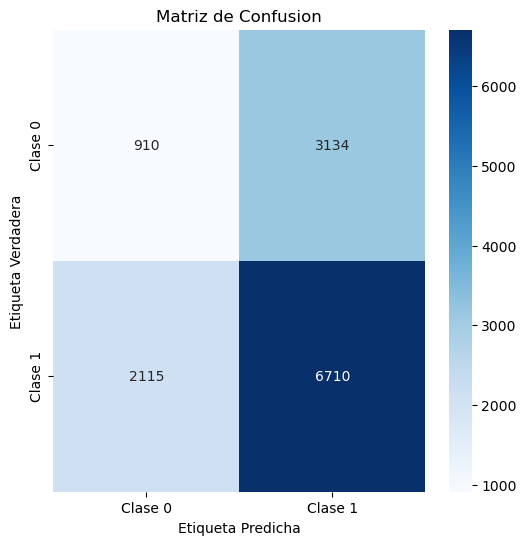

KeyboardInterrupt: 

In [66]:
from torch.nn import CrossEntropyLoss

# Hiperparametros
input_dim = 2   # Dimension de las caracteristicas de los nodos
hidden_dim = 16 # Numero de unidades en la capa oculta
output_dim = 2  # Numero de clases (clasificacion binaria de aristas)
heads = 4       # Numero de cabezas de atencion
dropout = 0.5   # Probabilidad de dropout

# Crear modelo GAT0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Definir dispositivo (GPU o CPU)
model = GAT(input_dim, hidden_dim, output_dim, heads=heads, dropout=dropout).to(device)

# Optimizador y funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Calcular pesos para cada clase
# Numero de ejemplos por clase
n_clase0 = 4044
n_clase1 = 7825
total = n_clase0 + n_clase1

# Pesos inversamente proporcionales a la frecuencia
weight = torch.tensor([1 - (n_clase0 / total), 1 - (n_clase1 / total)]).to(device)

# Crear la funcion de perdida
#loss_fn = CrossEntropyLoss(weight=weight)
loss_fn = CrossEntropyLoss()

# Entrenamiento
train_model(model, train_loader, optimizer, loss_fn, epochs=20)


### Ver datos para ver que esta pasando

In [30]:
# Visualizar un lote de datos para ver que esta pasando
for i, data in enumerate(train_loader):
    print(f"Batch {i + 1}:")
    print(f"x (nodos): {data.x.shape}")
    print(f"edge_index (aristas): {data.edge_index.shape}")
    print(f"data.y.shape: {data.y.shape}")
    print(f"data.y.numpy: {data.y.numpy()}")
    
    # Imprimir los primeros 5 nodos, aristas y atributos para revisar
    print(f"Nodos: {data.x[:]}")
    print(f"aristas: {data.edge_index[:, :]}")
    print(f" etiquetas de aristas: {data.y[:]}")
    
    # Romper el ciclo para no imprimir todo si tienes muchos datos
    if i == 2:
        break


Batch 1:
x (nodos): torch.Size([8, 2])
edge_index (aristas): torch.Size([2, 6])
data.y.shape: torch.Size([6])
data.y.numpy: [0 1 1 1 1 1]
Nodos: tensor([[46.,  1.],
        [47.,  2.],
        [47.,  3.],
        [47.,  4.],
        [ 7.,  1.],
        [ 7.,  2.],
        [ 7.,  3.],
        [ 7.,  4.]])
aristas: tensor([[0, 1, 2, 4, 5, 6],
        [1, 2, 3, 5, 6, 7]])
 etiquetas de aristas: tensor([0, 1, 1, 1, 1, 1])
Batch 2:
x (nodos): torch.Size([8, 2])
edge_index (aristas): torch.Size([2, 6])
data.y.shape: torch.Size([6])
data.y.numpy: [1 1 1 1 1 1]
Nodos: tensor([[58.,  1.],
        [59.,  2.],
        [59.,  3.],
        [59.,  4.],
        [11.,  1.],
        [12.,  2.],
        [11.,  3.],
        [12.,  4.]])
aristas: tensor([[0, 1, 2, 4, 5, 6],
        [1, 2, 3, 5, 6, 7]])
 etiquetas de aristas: tensor([1, 1, 1, 1, 1, 1])
Batch 3:
x (nodos): torch.Size([9, 2])
edge_index (aristas): torch.Size([2, 7])
data.y.shape: torch.Size([7])
data.y.numpy: [1 1 1 1 1 0 1]
Nodos: tensor([[

In [31]:
true_edges = 0
false_edges = 0

# Recorre el dataset
for data in valid_dataset:
    true_edges += (data.y == 1).sum().item()  # Cuenta las aristas verdaderas
    false_edges += (data.y == 0).sum().item()  # Cuenta las aristas falsas

print(f"True edges: {true_edges}")
print(f"False edges: {false_edges}")


True edges: 11180
False edges: 5140


### Validacion

In [48]:
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

def evaluate_model(model, test_loader, loss_fn):
    model.eval()  # Poner el modelo en modo evaluacion
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # No calcular gradientes durante la evaluacion
        for data in test_loader:
            data = data.to(device)  # Enviar datos a la GPU si esta disponible
            out = model(data.x, data.edge_index)  # Forward pass
            
            # Seleccionar las predicciones correspondientes a las aristas
            edge_predictions = out[data.edge_index[0]] + out[data.edge_index[1]]

            # Convertir las predicciones continuas a 0 o 1 (por ejemplo, umbral de 0.5 para clasificacion binaria)
            edge_predictions = (edge_predictions > 0.5).float()  # Para clasificacion binaria

            # Acumulamos las predicciones y las etiquetas verdaderas
            all_predictions.extend(edge_predictions.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            
            # Calcular la perdida
            loss = loss_fn(edge_predictions, data.y)
            total_loss += loss.item()
            
            # Calcular precision
            correct += (edge_predictions.argmax(dim=1) == data.y).sum().item()  # Ajustar segun el tipo de salida
            total += data.y.size(0)
    
    # Perdida promedio
    avg_loss = total_loss / len(test_loader)
    
    # Precision
    accuracy = correct / total
    
    # Calcular la matriz de confusion
    #cm = confusion_matrix(np.array(all_labels), np.array(all_predictions))
    
    return avg_loss, accuracy



In [49]:
# Suponiendo que ya tienes el modelo entrenado y el test_loader preparado

valid_loss, valid_accuracy = evaluate_model(model, test_loader, loss_fn)

print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")
#print(f"Confusion Matrix:\n{cm}")


Validation Loss: 0.6931
Validation Accuracy: 0.3178
